In [118]:
import warnings
warnings.simplefilter("ignore")

import time

# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
import scipy as sp

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# train, test, validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix

# models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

import xgboost as xgb
from xgboost.sklearn import XGBClassifier


# scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer

# decomposition
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF

# feature engineering
from sklearn.preprocessing import PolynomialFeatures
from sklearn.manifold import TSNE

# feature selection
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

In [2]:
# Utility function to report best scores
def report(results, n_top=3):
    """Utility function to report best scores
    """
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Rank: {0}".format(i))
            print("Score: {0:f} (std: {1:f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Pars: {0}".format(results['params'][candidate]))
            print("")
            

def report2(results, n_top=3):
    """Utility function to report best scores
    """
    print("Rank|Score(std)|Params", list(results['params'][0].keys()))
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("{0}|".format(i), end="")
            print("{0:f}(std:{1:f})|".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]), end="")
            print("{0}".format(list(results['params'][candidate].values())))

In [3]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')
combine = [train_df, test_df]

In [4]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


----
# modify features

## make ticket length feature
https://www.kaggle.com/yuanxuan/titanic-random-forest-82-78/notebook

In [5]:
train_df['Ticket_Len'] = train_df['Ticket'].apply(lambda x: len(x))
test_df['Ticket_Len'] = test_df['Ticket'].apply(lambda x: len(x))
combine = [train_df, test_df]

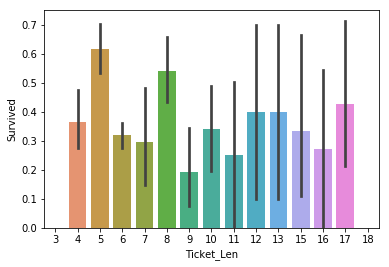

In [6]:
sns.barplot(data=train_df, x="Ticket_Len", y="Survived")

In [7]:
train_df['Ticket_Len'].value_counts(dropna=False)

6     419
5     131
4     101
8      76
10     41
7      27
9      26
17     14
16     11
13     10
12     10
15      9
11      8
18      6
3       2
Name: Ticket_Len, dtype: int64

In [8]:
test_df['Ticket_Len'].value_counts(dropna=False)

6     183
5      62
4      47
8      42
10     22
9      11
11     10
13      9
7       9
18      8
12      6
15      3
17      2
16      2
3       2
Name: Ticket_Len, dtype: int64

In [9]:
# first char of Ticket seems Pclass
train_df[["Pclass", "Ticket", "Ticket_Len"]]

,Pclass,Ticket,Ticket_Len
0,3,A/5 21171,9
1,1,PC 17599,8
2,3,STON/O2. 3101282,16
3,1,113803,6
4,3,373450,6
5,3,330877,6
6,1,17463,5
7,3,349909,6
8,3,347742,6
9,2,237736,6


----

## make Cabin First character feature

In [10]:
train_df["Cabin_Letter"] = train_df["Cabin"].fillna('0').apply(lambda x: x[0])
test_df["Cabin_Letter"] = test_df["Cabin"].fillna('0').apply(lambda x: x[0])
combine = [train_df, test_df]

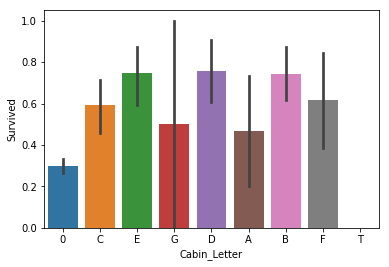

In [11]:
sns.barplot(data=train_df, x="Cabin_Letter", y="Survived")

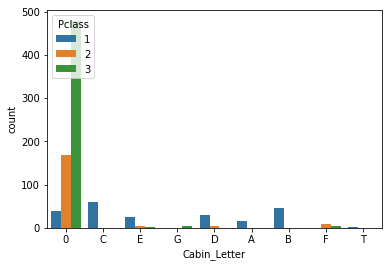

In [12]:
sns.countplot(data=train_df, x="Cabin_Letter", hue="Pclass")

In [13]:
train_df["Cabin_Letter"].value_counts(dropna=False)

0    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin_Letter, dtype: int64

In [14]:
test_df["Cabin_Letter"].value_counts(dropna=False)

0    327
C     35
B     18
D     13
E      9
F      8
A      7
G      1
Name: Cabin_Letter, dtype: int64

In [15]:
train_df[["Cabin", "Cabin_Letter"]]

,Cabin,Cabin_Letter
0,NaN,0
1,C85,C
2,NaN,0
3,C123,C
4,NaN,0
5,NaN,0
6,E46,E
7,NaN,0
8,NaN,0
9,NaN,0


### make one Cabin_Letter feature by numerical

### make dummy variable for Cabin_Letter

In [16]:
train_test_df = pd.concat((train_df, test_df))

# apply get_dummies for Cabin_Letter
train_test_df = pd.get_dummies(train_test_df, columns=["Cabin_Letter"])

train_df = train_test_df.iloc[:train_df.shape[0]]

test_df = train_test_df.iloc[train_df.shape[0]:]
test_df = test_df.drop("Survived", axis=1) # drop added Survived column from test_df

combine = [train_df, test_df]

**if you made Cabin_num features too, duplicate feature for NaN. delete one of these**

In [17]:
train_df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,Ticket_Len,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,Cabin_Letter_T
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,...,9,1,0,0,0,0,0,0,0,0
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,...,8,0,0,0,1,0,0,0,0,0
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,...,16,1,0,0,0,0,0,0,0,0
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,...,6,0,0,0,1,0,0,0,0,0
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,...,6,1,0,0,0,0,0,0,0,0


In [18]:
train_df.columns

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId',
       'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket', 'Ticket_Len',
       'Cabin_Letter_0', 'Cabin_Letter_A', 'Cabin_Letter_B', 'Cabin_Letter_C',
       'Cabin_Letter_D', 'Cabin_Letter_E', 'Cabin_Letter_F', 'Cabin_Letter_G',
       'Cabin_Letter_T'],
      dtype='object')

In [19]:
test_df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,Ticket_Len,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,Cabin_Letter_T
0,34.5,NaN,Q,7.8292,"Kelly, Mr. James",0,892,3,male,0,...,6,1,0,0,0,0,0,0,0,0
1,47.0,NaN,S,7.0000,"Wilkes, Mrs. James (Ellen Needs)",0,893,3,female,1,...,6,1,0,0,0,0,0,0,0,0
2,62.0,NaN,Q,9.6875,"Myles, Mr. Thomas Francis",0,894,2,male,0,...,6,1,0,0,0,0,0,0,0,0
3,27.0,NaN,S,8.6625,"Wirz, Mr. Albert",0,895,3,male,0,...,6,1,0,0,0,0,0,0,0,0
4,22.0,NaN,S,12.2875,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,896,3,female,1,...,7,1,0,0,0,0,0,0,0,0


----

## make CabinBool feature
**I think the idea here is that people with recorded cabin numbers are of higher socioeconomic class, and thus more likely to survive. **
https://www.kaggle.com/nadintamer/titanic-survival-predictions-beginner

- I tried it
  - but gradient boosting result became worse. from 0.79904 to 0.77990
  - more than cabinbool is necessary? should i use first letter of cabin name?

**CabinBool is inclueded in Cabin letter and cabin number**
**no need to use**

----

## make Cabin number feature
https://www.kaggle.com/yuanxuan/titanic-random-forest-82-78/notebook

In [20]:
#for i in [train_df, test_df]:
for i in combine:
    i['Cabin_num'] = i['Cabin'].apply(lambda x: str(x).split(' ')[-1][1:])
    i['Cabin_num'].replace('an', np.NaN, inplace = True)
    i['Cabin_num'] = i['Cabin_num'].apply(lambda x: int(x) if not pd.isnull(x) and x != '' else np.NaN)


/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/yuki/.local/lib/python3.6/site-packages/pandas/core/generic.py:4619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [21]:
train_df[["Cabin", "Cabin_num"]]

,Cabin,Cabin_num
0,NaN,NaN
1,C85,85.0
2,NaN,NaN
3,C123,123.0
4,NaN,NaN
5,NaN,NaN
6,E46,46.0
7,NaN,NaN
8,NaN,NaN
9,NaN,NaN


In [22]:
test_df[["Cabin", "Cabin_num"]]

,Cabin,Cabin_num
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
5,NaN,NaN
6,NaN,NaN
7,NaN,NaN
8,NaN,NaN
9,NaN,NaN


In [23]:
train_df['Cabin_num_Band'] = pd.qcut(train_df['Cabin_num'], 3)

train_df['Cabin_num_Band'].value_counts(dropna=False) 

#NaN                 691
#(65.667, 148.0]      67
#(1.999, 28.667]      67
#(28.667, 65.667]     66


/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


NaN                 691
(65.667, 148.0]      67
(1.999, 28.667]      67
(28.667, 65.667]     66
Name: Cabin_num_Band, dtype: int64

In [24]:
train_df['Cabin_num_Band'] = train_df['Cabin_num_Band'].cat.add_categories("nan_category")
train_df['Cabin_num_Band'] = train_df['Cabin_num_Band'].fillna("nan_category")


/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [25]:
train_df.groupby(["Cabin_num_Band"])["Survived"].value_counts(dropna=False)

Cabin_num_Band    Survived
(1.999, 28.667]   1.0          48
                  0.0          19
(28.667, 65.667]  1.0          43
                  0.0          23
(65.667, 148.0]   1.0          43
                  0.0          24
nan_category      0.0         483
                  1.0         208
Name: Survived, dtype: int64

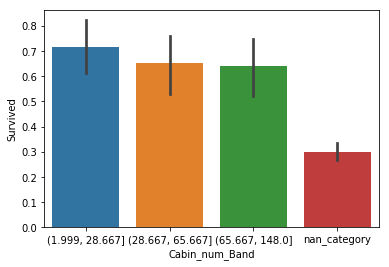

In [26]:
sns.barplot(data=train_df, x="Cabin_num_Band", y="Survived")

In [27]:
# 3 cabin num band
combine = [train_df, test_df]
for dataset in combine:
    dataset.loc[ dataset['Cabin_num'] <= 28.667, 'Cabin_num'] = 0
    dataset.loc[(dataset['Cabin_num'] > 28.667) & (dataset['Cabin_num'] <= 65.667), 'Cabin_num'] = 1
    dataset.loc[ dataset['Cabin_num'] > 65.667, 'Cabin_num'] = 2
combine = [train_df, test_df]


/home/yuki/.local/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [28]:
train_df[['Cabin_num', 'Cabin_num_Band']]

,Cabin_num,Cabin_num_Band
0,NaN,nan_category
1,2.0,"(65.667, 148.0]"
2,NaN,nan_category
3,2.0,"(65.667, 148.0]"
4,NaN,nan_category
5,NaN,nan_category
6,1.0,"(28.667, 65.667]"
7,NaN,nan_category
8,NaN,nan_category
9,NaN,nan_category


In [29]:
test_df[['Cabin_num']]

,Cabin_num
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
5,NaN
6,NaN
7,NaN
8,NaN
9,NaN


In [30]:
train_df = train_df.drop(['Cabin_num_Band'], axis=1)
combine = [train_df, test_df]

In [31]:
train_df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,Cabin_Letter_T,Cabin_num
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,...,1,0,0,0,0,0,0,0,0,NaN
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,...,0,0,0,1,0,0,0,0,0,2.0
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,...,1,0,0,0,0,0,0,0,0,NaN
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,...,0,0,0,1,0,0,0,0,0,2.0
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,...,1,0,0,0,0,0,0,0,0,NaN


In [32]:
test_df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,Cabin_Letter_T,Cabin_num
0,34.5,NaN,Q,7.8292,"Kelly, Mr. James",0,892,3,male,0,...,1,0,0,0,0,0,0,0,0,NaN
1,47.0,NaN,S,7.0000,"Wilkes, Mrs. James (Ellen Needs)",0,893,3,female,1,...,1,0,0,0,0,0,0,0,0,NaN
2,62.0,NaN,Q,9.6875,"Myles, Mr. Thomas Francis",0,894,2,male,0,...,1,0,0,0,0,0,0,0,0,NaN
3,27.0,NaN,S,8.6625,"Wirz, Mr. Albert",0,895,3,male,0,...,1,0,0,0,0,0,0,0,0,NaN
4,22.0,NaN,S,12.2875,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,896,3,female,1,...,1,0,0,0,0,0,0,0,0,NaN


In [33]:
train_df = pd.concat((train_df, pd.get_dummies(train_df['Cabin_num'], prefix='Cabin_num', dummy_na=True)), axis = 1)
test_df = pd.concat((test_df, pd.get_dummies(test_df['Cabin_num'], prefix='Cabin_num', dummy_na=True)), axis = 1)
combine = [train_df, test_df]

In [34]:
train_df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,Cabin_Letter_T,Cabin_num,Cabin_num_0.0,Cabin_num_1.0,Cabin_num_2.0,Cabin_num_nan
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,...,0,0,0,0,0,NaN,0,0,0,1
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,...,0,0,0,0,0,2.0,0,0,1,0
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,...,0,0,0,0,0,NaN,0,0,0,1
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,...,0,0,0,0,0,2.0,0,0,1,0
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,...,0,0,0,0,0,NaN,0,0,0,1


In [35]:
test_df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,Cabin_Letter_T,Cabin_num,Cabin_num_0.0,Cabin_num_1.0,Cabin_num_2.0,Cabin_num_nan
0,34.5,NaN,Q,7.8292,"Kelly, Mr. James",0,892,3,male,0,...,0,0,0,0,0,NaN,0,0,0,1
1,47.0,NaN,S,7.0000,"Wilkes, Mrs. James (Ellen Needs)",0,893,3,female,1,...,0,0,0,0,0,NaN,0,0,0,1
2,62.0,NaN,Q,9.6875,"Myles, Mr. Thomas Francis",0,894,2,male,0,...,0,0,0,0,0,NaN,0,0,0,1
3,27.0,NaN,S,8.6625,"Wirz, Mr. Albert",0,895,3,male,0,...,0,0,0,0,0,NaN,0,0,0,1
4,22.0,NaN,S,12.2875,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,896,3,female,1,...,0,0,0,0,0,NaN,0,0,0,1


In [36]:
train_df.columns

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId',
       'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket', 'Ticket_Len',
       'Cabin_Letter_0', 'Cabin_Letter_A', 'Cabin_Letter_B', 'Cabin_Letter_C',
       'Cabin_Letter_D', 'Cabin_Letter_E', 'Cabin_Letter_F', 'Cabin_Letter_G',
       'Cabin_Letter_T', 'Cabin_num', 'Cabin_num_0.0', 'Cabin_num_1.0',
       'Cabin_num_2.0', 'Cabin_num_nan'],
      dtype='object')

In [37]:
del train_df['Cabin_num']
del test_df['Cabin_num']
combine = [train_df, test_df]

In [38]:
train_df.columns

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId',
       'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket', 'Ticket_Len',
       'Cabin_Letter_0', 'Cabin_Letter_A', 'Cabin_Letter_B', 'Cabin_Letter_C',
       'Cabin_Letter_D', 'Cabin_Letter_E', 'Cabin_Letter_F', 'Cabin_Letter_G',
       'Cabin_Letter_T', 'Cabin_num_0.0', 'Cabin_num_1.0', 'Cabin_num_2.0',
       'Cabin_num_nan'],
      dtype='object')

----

## del Ticket, Cabin columns

In [39]:
# del Ticket, Cabin columns
train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

In [40]:
train_df.head()

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,...,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,Cabin_Letter_T,Cabin_num_0.0,Cabin_num_1.0,Cabin_num_2.0,Cabin_num_nan
0,22.0,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,...,0,0,0,0,0,0,0,0,0,1
1,38.0,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,...,1,0,0,0,0,0,0,0,1,0
2,26.0,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,...,0,0,0,0,0,0,0,0,0,1
3,35.0,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,...,1,0,0,0,0,0,0,0,1,0
4,35.0,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,...,0,0,0,0,0,0,0,0,0,1


In [41]:
train_df.columns

Index(['Age', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId', 'Pclass',
       'Sex', 'SibSp', 'Survived', 'Ticket_Len', 'Cabin_Letter_0',
       'Cabin_Letter_A', 'Cabin_Letter_B', 'Cabin_Letter_C', 'Cabin_Letter_D',
       'Cabin_Letter_E', 'Cabin_Letter_F', 'Cabin_Letter_G', 'Cabin_Letter_T',
       'Cabin_num_0.0', 'Cabin_num_1.0', 'Cabin_num_2.0', 'Cabin_num_nan'],
      dtype='object')

----

## add title

In [42]:
# add title
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

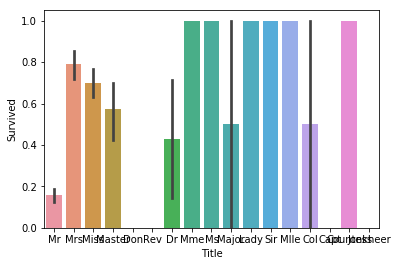

In [43]:
sns.barplot(data=train_df, x="Title", y="Survived")

In [44]:
train_df.Title.value_counts(dropna=False)

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Major         2
Mlle          2
Ms            1
Don           1
Mme           1
Sir           1
Jonkheer      1
Lady          1
Capt          1
Countess      1
Name: Title, dtype: int64

----

## make name length feature

In [45]:
train_df['Name_Len'] = train_df['Name'].apply(lambda x: len(x))
test_df['Name_Len'] = test_df['Name'].apply(lambda x: len(x))
combine = [train_df, test_df]

In [46]:
train_df.head()

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,...,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,Cabin_Letter_T,Cabin_num_0.0,Cabin_num_1.0,Cabin_num_2.0,Cabin_num_nan,Title,Name_Len
0,22.0,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,...,0,0,0,0,0,0,0,1,Mr,23
1,38.0,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,...,0,0,0,0,0,0,1,0,Mrs,51
2,26.0,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,...,0,0,0,0,0,0,0,1,Miss,22
3,35.0,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,...,0,0,0,0,0,0,1,0,Mrs,44
4,35.0,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,...,0,0,0,0,0,0,0,1,Mr,24


In [47]:
train_df["Name_Len"].value_counts(dropna=False)

19    64
25    55
27    50
18    50
26    49
28    43
24    43
17    42
21    40
23    39
20    39
22    38
30    37
29    32
31    30
16    26
32    23
33    22
15    15
47    11
37    10
38     9
36     9
39     9
45     9
44     8
41     8
34     7
46     7
40     7
51     7
35     6
43     5
42     5
49     5
50     4
52     4
56     3
14     3
48     3
13     2
12     2
53     2
55     2
57     2
67     1
54     1
61     1
65     1
82     1
Name: Name_Len, dtype: int64

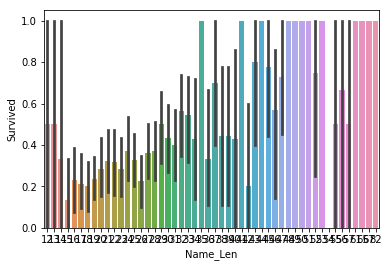

In [48]:
sns.barplot(data=train_df, x="Name_Len", y="Survived")

In [49]:
train_df.groupby("Name_Len").Survived.mean()

Name_Len
12    0.500000
13    0.500000
14    0.333333
15    0.133333
16    0.230769
17    0.214286
18    0.200000
19    0.234375
20    0.282051
21    0.325000
22    0.315789
23    0.282051
24    0.372093
25    0.327273
26    0.224490
27    0.360000
28    0.372093
29    0.500000
30    0.432432
31    0.400000
32    0.565217
33    0.545455
34    0.428571
35    1.000000
36    0.333333
37    0.700000
38    0.444444
39    0.444444
40    0.428571
41    1.000000
42    0.200000
43    0.800000
44    1.000000
45    0.777778
46    0.571429
47    0.727273
48    1.000000
49    1.000000
50    1.000000
51    1.000000
52    0.750000
53    1.000000
54    0.000000
55    0.500000
56    0.666667
57    0.500000
61    1.000000
65    1.000000
67    1.000000
82    1.000000
Name: Survived, dtype: float64

----

## map value to Sex 

In [50]:
for dataset in combine:
    dataset["Sex"] = dataset["Sex"].map({'female':1, 'male':0}).astype(int)

In [51]:
train_df.head()

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,...,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,Cabin_Letter_T,Cabin_num_0.0,Cabin_num_1.0,Cabin_num_2.0,Cabin_num_nan,Title,Name_Len
0,22.0,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,0,1,0.0,...,0,0,0,0,0,0,0,1,Mr,23
1,38.0,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,1,1.0,...,0,0,0,0,0,0,1,0,Mrs,51
2,26.0,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,1,0,1.0,...,0,0,0,0,0,0,0,1,Miss,22
3,35.0,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,1,1.0,...,0,0,0,0,0,0,1,0,Mrs,44
4,35.0,S,8.0500,"Allen, Mr. William Henry",0,5,3,0,0,0.0,...,0,0,0,0,0,0,0,1,Mr,24


----

## make Age_Null_Flag if the Age is nulll

In [52]:
train_df['Age_Null_Flag'] = train_df['Age'].apply(lambda x: 1 if pd.isnull(x) else 0)
test_df['Age_Null_Flag'] = test_df['Age'].apply(lambda x: 1 if pd.isnull(x) else 0)
combine = [train_df, test_df]

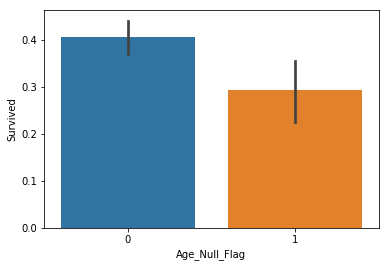

In [53]:
sns.barplot(data=train_df, x="Age_Null_Flag", y="Survived")

In [54]:
train_df["Age_Null_Flag"].value_counts(dropna=False)

0    714
1    177
Name: Age_Null_Flag, dtype: int64

In [55]:
test_df["Age_Null_Flag"].value_counts(dropna=False)

0    332
1     86
Name: Age_Null_Flag, dtype: int64

In [56]:
train_df.head(20)

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,...,Cabin_Letter_F,Cabin_Letter_G,Cabin_Letter_T,Cabin_num_0.0,Cabin_num_1.0,Cabin_num_2.0,Cabin_num_nan,Title,Name_Len,Age_Null_Flag
0,22.0,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,0,1,0.0,...,0,0,0,0,0,0,1,Mr,23,0
1,38.0,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,1,1.0,...,0,0,0,0,0,1,0,Mrs,51,0
2,26.0,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,1,0,1.0,...,0,0,0,0,0,0,1,Miss,22,0
3,35.0,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,1,1.0,...,0,0,0,0,0,1,0,Mrs,44,0
4,35.0,S,8.0500,"Allen, Mr. William Henry",0,5,3,0,0,0.0,...,0,0,0,0,0,0,1,Mr,24,0
5,NaN,Q,8.4583,"Moran, Mr. James",0,6,3,0,0,0.0,...,0,0,0,0,0,0,1,Mr,16,1
6,54.0,S,51.8625,"McCarthy, Mr. Timothy J",0,7,1,0,0,0.0,...,0,0,0,0,1,0,0,Mr,23,0
7,2.0,S,21.0750,"Palsson, Master. Gosta Leonard",1,8,3,0,3,0.0,...,0,0,0,0,0,0,1,Master,30,0
8,27.0,S,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,3,1,0,1.0,...,0,0,0,0,0,0,1,Mrs,49,0
9,14.0,C,30.0708,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,2,1,1,1.0,...,0,0,0,0,0,0,1,Mrs,35,0


In [57]:
test_df.head(20)

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Ticket_Len,...,Cabin_Letter_F,Cabin_Letter_G,Cabin_Letter_T,Cabin_num_0.0,Cabin_num_1.0,Cabin_num_2.0,Cabin_num_nan,Title,Name_Len,Age_Null_Flag
0,34.5,Q,7.8292,"Kelly, Mr. James",0,892,3,0,0,6,...,0,0,0,0,0,0,1,Mr,16,0
1,47.0,S,7.0000,"Wilkes, Mrs. James (Ellen Needs)",0,893,3,1,1,6,...,0,0,0,0,0,0,1,Mrs,32,0
2,62.0,Q,9.6875,"Myles, Mr. Thomas Francis",0,894,2,0,0,6,...,0,0,0,0,0,0,1,Mr,25,0
3,27.0,S,8.6625,"Wirz, Mr. Albert",0,895,3,0,0,6,...,0,0,0,0,0,0,1,Mr,16,0
4,22.0,S,12.2875,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,896,3,1,1,7,...,0,0,0,0,0,0,1,Mrs,44,0
5,14.0,S,9.2250,"Svensson, Mr. Johan Cervin",0,897,3,0,0,4,...,0,0,0,0,0,0,1,Mr,26,0
6,30.0,Q,7.6292,"Connolly, Miss. Kate",0,898,3,1,0,6,...,0,0,0,0,0,0,1,Miss,20,0
7,26.0,S,29.0000,"Caldwell, Mr. Albert Francis",1,899,2,0,1,6,...,0,0,0,0,0,0,1,Mr,28,0
8,18.0,C,7.2292,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",0,900,3,1,0,4,...,0,0,0,0,0,0,1,Mrs,41,0
9,21.0,S,24.1500,"Davies, Mr. John Samuel",0,901,3,0,2,9,...,0,0,0,0,0,0,1,Mr,23,0


----

## fill na of Age

options

- by Sex and Pclass
- by Title and Pclass

In [58]:
pd.cut(train_df['Age'], 5).value_counts(dropna=False)

(16.336, 32.252]    346
(32.252, 48.168]    188
NaN                 177
(0.34, 16.336]      100
(48.168, 64.084]     69
(64.084, 80.0]       11
Name: Age, dtype: int64

### by Sex and Pclass

### fill nan of Age by Title and Pclass
https://www.kaggle.com/yuanxuan/titanic-random-forest-82-78/notebook

There is mistake in the original notebook.
test_df was filled by train_df.
So I modified.

In [59]:
train_test_df = pd.concat((train_df, test_df))

groupedAge_train_test = train_test_df.groupby(['Title', 'Pclass'])['Age']

# fill by title and pclass. 
# but one grouped row doesn't have Age num. 
# So need to group by only Title and fill of the mean value.
train_test_df.Age = groupedAge_train_test.transform(lambda x:x.fillna(x.mean()))

# fill by just title because no value row if group by title and pclass
groupedByTitleOnly_Age_train_test = train_test_df.groupby(['Title'])['Age']
train_test_df.Age = groupedByTitleOnly_Age_train_test.transform(lambda x:x.fillna(x.mean()))

train_df = train_test_df.iloc[:train_df.shape[0]]
test_df = train_test_df.iloc[train_df.shape[0]:]

test_df = test_df.drop(["Survived"], axis=1)

combine = [train_df, test_df]

In [60]:
groupedAge_train_test.mean()

Title     Pclass
Capt      1         70.000000
Col       1         54.000000
Countess  1         33.000000
Don       1         40.000000
Dona      1         39.000000
Dr        1         45.600000
          2         38.500000
Jonkheer  1         38.000000
Lady      1         48.000000
Major     1         48.500000
Master    1          6.984000
          2          2.757273
          3          6.090000
Miss      1         30.338983
          2         20.717083
          3         17.360874
Mlle      1         24.000000
Mme       1         24.000000
Mr        1         41.450758
          2         32.346715
          3         28.318910
Mrs       1         43.208955
          2         33.518519
          3         32.326531
Ms        2         28.000000
          3         28.000000
Rev       2         41.250000
Sir       1         49.000000
Name: Age, dtype: float64

In [61]:
train_test_df.Age.isna().any()

False

In [62]:
train_df.shape, test_df.shape

((891, 27), (418, 26))

In [63]:
train_df.head(30)

,Age,Age_Null_Flag,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,...,Name,Name_Len,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket_Len,Title
0,22.000000,0,1,0,0,0,0,0,0,0,...,"Braund, Mr. Owen Harris",23,0,1,3,0,1,0.0,9,Mr
1,38.000000,0,0,0,0,1,0,0,0,0,...,"Cumings, Mrs. John Bradley (Florence Briggs Th...",51,0,2,1,1,1,1.0,8,Mrs
2,26.000000,0,1,0,0,0,0,0,0,0,...,"Heikkinen, Miss. Laina",22,0,3,3,1,0,1.0,16,Miss
3,35.000000,0,0,0,0,1,0,0,0,0,...,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",44,0,4,1,1,1,1.0,6,Mrs
4,35.000000,0,1,0,0,0,0,0,0,0,...,"Allen, Mr. William Henry",24,0,5,3,0,0,0.0,6,Mr
5,28.318910,1,1,0,0,0,0,0,0,0,...,"Moran, Mr. James",16,0,6,3,0,0,0.0,6,Mr
6,54.000000,0,0,0,0,0,0,1,0,0,...,"McCarthy, Mr. Timothy J",23,0,7,1,0,0,0.0,5,Mr
7,2.000000,0,1,0,0,0,0,0,0,0,...,"Palsson, Master. Gosta Leonard",30,1,8,3,0,3,0.0,6,Master
8,27.000000,0,1,0,0,0,0,0,0,0,...,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",49,2,9,3,1,0,1.0,6,Mrs
9,14.000000,0,1,0,0,0,0,0,0,0,...,"Nasser, Mrs. Nicholas (Adele Achem)",35,0,10,2,1,1,1.0,6,Mrs


In [64]:
test_df.head(30)

,Age,Age_Null_Flag,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,...,Fare,Name,Name_Len,Parch,PassengerId,Pclass,Sex,SibSp,Ticket_Len,Title
0,34.500000,0,1,0,0,0,0,0,0,0,...,7.8292,"Kelly, Mr. James",16,0,892,3,0,0,6,Mr
1,47.000000,0,1,0,0,0,0,0,0,0,...,7.0000,"Wilkes, Mrs. James (Ellen Needs)",32,0,893,3,1,1,6,Mrs
2,62.000000,0,1,0,0,0,0,0,0,0,...,9.6875,"Myles, Mr. Thomas Francis",25,0,894,2,0,0,6,Mr
3,27.000000,0,1,0,0,0,0,0,0,0,...,8.6625,"Wirz, Mr. Albert",16,0,895,3,0,0,6,Mr
4,22.000000,0,1,0,0,0,0,0,0,0,...,12.2875,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",44,1,896,3,1,1,7,Mrs
5,14.000000,0,1,0,0,0,0,0,0,0,...,9.2250,"Svensson, Mr. Johan Cervin",26,0,897,3,0,0,4,Mr
6,30.000000,0,1,0,0,0,0,0,0,0,...,7.6292,"Connolly, Miss. Kate",20,0,898,3,1,0,6,Miss
7,26.000000,0,1,0,0,0,0,0,0,0,...,29.0000,"Caldwell, Mr. Albert Francis",28,1,899,2,0,1,6,Mr
8,18.000000,0,1,0,0,0,0,0,0,0,...,7.2292,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",41,0,900,3,1,0,4,Mrs
9,21.000000,0,1,0,0,0,0,0,0,0,...,24.1500,"Davies, Mr. John Samuel",23,0,901,3,0,2,9,Mr


In [65]:
train_df.isna().any()

Age               False
Age_Null_Flag     False
Cabin_Letter_0    False
Cabin_Letter_A    False
Cabin_Letter_B    False
Cabin_Letter_C    False
Cabin_Letter_D    False
Cabin_Letter_E    False
Cabin_Letter_F    False
Cabin_Letter_G    False
Cabin_Letter_T    False
Cabin_num_0.0     False
Cabin_num_1.0     False
Cabin_num_2.0     False
Cabin_num_nan     False
Embarked           True
Fare              False
Name              False
Name_Len          False
Parch             False
PassengerId       False
Pclass            False
Sex               False
SibSp             False
Survived          False
Ticket_Len        False
Title             False
dtype: bool

In [66]:
test_df.isna().any()

Age               False
Age_Null_Flag     False
Cabin_Letter_0    False
Cabin_Letter_A    False
Cabin_Letter_B    False
Cabin_Letter_C    False
Cabin_Letter_D    False
Cabin_Letter_E    False
Cabin_Letter_F    False
Cabin_Letter_G    False
Cabin_Letter_T    False
Cabin_num_0.0     False
Cabin_num_1.0     False
Cabin_num_2.0     False
Cabin_num_nan     False
Embarked          False
Fare               True
Name              False
Name_Len          False
Parch             False
PassengerId       False
Pclass            False
Sex               False
SibSp             False
Ticket_Len        False
Title             False
dtype: bool

#### tried keep Age feature and don't add AgeBand numerical feature
if both are there, it is duplicate information

**2018/03/17 tried Age instead of Age band. But AgeBand is better score for almost all models.**
svc score was same of little bit better.
random forest score became worse.
so AgeBand is better

----

### add age band

- 5 age band by pd.cut
- 10 age band by pd.cut: this is better score.

if i use pd.qcut, band become too short for young adult around 25.

**first, check age band and Survived feature in train_df**

In [67]:
pd.cut(train_df['Age'], 5).value_counts(dropna=False)

(16.336, 32.252]    472
(32.252, 48.168]    235
(0.34, 16.336]      104
(48.168, 64.084]     69
(64.084, 80.0]       11
Name: Age, dtype: int64

In [68]:
pd.cut(train_df['Age'], 10).value_counts(dropna=False)

(24.294, 32.252]    260
(16.336, 24.294]    212
(32.252, 40.21]     136
(40.21, 48.168]      99
(0.34, 8.378]        58
(8.378, 16.336]      46
(48.168, 56.126]     45
(56.126, 64.084]     24
(64.084, 72.042]      9
(72.042, 80.0]        2
Name: Age, dtype: int64

In [69]:
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
combine = [train_df, test_df]

/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


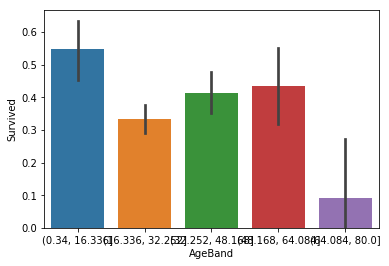

In [70]:
sns.barplot(x="AgeBand", data=train_df, y="Survived")

In [71]:
train_df.groupby(["AgeBand"]).Survived.value_counts()

AgeBand           Survived
(0.34, 16.336]    1.0          57
                  0.0          47
(16.336, 32.252]  0.0         315
                  1.0         157
(32.252, 48.168]  0.0         138
                  1.0          97
(48.168, 64.084]  0.0          39
                  1.0          30
(64.084, 80.0]    0.0          10
                  1.0           1
Name: Survived, dtype: int64

In [72]:
train_df[["Age", "AgeBand"]]

,Age,AgeBand
0,22.000000,"(16.336, 32.252]"
1,38.000000,"(32.252, 48.168]"
2,26.000000,"(16.336, 32.252]"
3,35.000000,"(32.252, 48.168]"
4,35.000000,"(32.252, 48.168]"
5,28.318910,"(16.336, 32.252]"
6,54.000000,"(48.168, 64.084]"
7,2.000000,"(0.34, 16.336]"
8,27.000000,"(16.336, 32.252]"
9,14.000000,"(0.34, 16.336]"


### Overwrite AgeBand number on Age. means, drop Age and AgeBand text column

In [73]:
# 5 age band
combine = [train_df, test_df]
for dataset in combine:
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4
train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]

/home/yuki/.local/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [74]:
train_df.head()

,Age,Age_Null_Flag,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,...,Name,Name_Len,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket_Len,Title
0,1.0,0,1,0,0,0,0,0,0,0,...,"Braund, Mr. Owen Harris",23,0,1,3,0,1,0.0,9,Mr
1,2.0,0,0,0,0,1,0,0,0,0,...,"Cumings, Mrs. John Bradley (Florence Briggs Th...",51,0,2,1,1,1,1.0,8,Mrs
2,1.0,0,1,0,0,0,0,0,0,0,...,"Heikkinen, Miss. Laina",22,0,3,3,1,0,1.0,16,Miss
3,2.0,0,0,0,0,1,0,0,0,0,...,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",44,0,4,1,1,1,1.0,6,Mrs
4,2.0,0,1,0,0,0,0,0,0,0,...,"Allen, Mr. William Henry",24,0,5,3,0,0,0.0,6,Mr


In [75]:
test_df.head()

,Age,Age_Null_Flag,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,...,Fare,Name,Name_Len,Parch,PassengerId,Pclass,Sex,SibSp,Ticket_Len,Title
0,2.0,0,1,0,0,0,0,0,0,0,...,7.8292,"Kelly, Mr. James",16,0,892,3,0,0,6,Mr
1,2.0,0,1,0,0,0,0,0,0,0,...,7.0000,"Wilkes, Mrs. James (Ellen Needs)",32,0,893,3,1,1,6,Mrs
2,3.0,0,1,0,0,0,0,0,0,0,...,9.6875,"Myles, Mr. Thomas Francis",25,0,894,2,0,0,6,Mr
3,1.0,0,1,0,0,0,0,0,0,0,...,8.6625,"Wirz, Mr. Albert",16,0,895,3,0,0,6,Mr
4,1.0,0,1,0,0,0,0,0,0,0,...,12.2875,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",44,1,896,3,1,1,7,Mrs


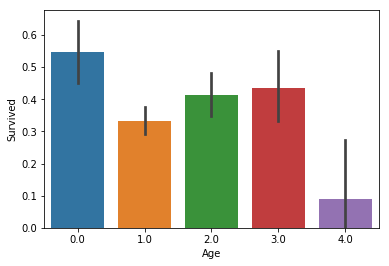

In [76]:
sns.barplot(data=train_df, x="Age", y="Survived")

----

## convert Title to numerical or one hot encoding

several options

1. one hot encoding, no deleting rare title
2. change rare title to "Rare" and map value
  - 2.1. Replacing rare titles with more common ones
3. modify known title to usual, change rare title to "Rare" and one hot encoding

In [77]:
train_df.Title.value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Major         2
Mlle          2
Ms            1
Don           1
Mme           1
Sir           1
Jonkheer      1
Lady          1
Capt          1
Countess      1
Name: Title, dtype: int64

### 1. one hot encoding, no deleteing rare title

### 2. change rare titles to "Rare" and map value

**del rare title and map value**

#### 2.1. Replacing rare titles with more common ones**

https://www.kaggle.com/konstantinmasich/titanic-0-82-0-83/

### 3. modify known title to usual, change rare title to "Rare" and one hot encoding

In [78]:
mapping = {'Mlle': 'Miss', 
            'Major': 'Mr', 
            'Col': 'Mr', 
            'Sir': 'Mr',
            'Don': 'Mr', 
            'Mme': 'Miss',
            'Jonkheer': 'Mr',
            'Lady': 'Mrs', 
            'Capt': 'Mr', 
            'Countess': 'Mrs',
            'Ms': 'Miss',
            'Dona': 'Mrs'}

train_df.replace({'Title': mapping}, inplace=True)
test_df.replace({'Title': mapping}, inplace=True)

combine = [train_df, test_df]

train_test_df = pd.concat((train_df, test_df))
train_test_df = pd.get_dummies(train_test_df, columns=["Title"])

train_df = train_test_df.iloc[:train_df.shape[0]]
test_df = train_test_df.iloc[train_df.shape[0]:]

test_df = test_df.drop("Survived", axis=1)
print(train_df.shape, test_df.shape)

combine = [train_df, test_df]

(891, 32) (418, 31)


In [79]:
train_df.columns

Index(['Age', 'Age_Null_Flag', 'Cabin_Letter_0', 'Cabin_Letter_A',
       'Cabin_Letter_B', 'Cabin_Letter_C', 'Cabin_Letter_D', 'Cabin_Letter_E',
       'Cabin_Letter_F', 'Cabin_Letter_G', 'Cabin_Letter_T', 'Cabin_num_0.0',
       'Cabin_num_1.0', 'Cabin_num_2.0', 'Cabin_num_nan', 'Embarked', 'Fare',
       'Name', 'Name_Len', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp',
       'Survived', 'Ticket_Len', 'Title_Dr', 'Title_Master', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'Title_Rev'],
      dtype='object')

In [80]:
train_df.head()

,Age,Age_Null_Flag,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,...,Sex,SibSp,Survived,Ticket_Len,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev
0,1.0,0,1,0,0,0,0,0,0,0,...,0,1,0.0,9,0,0,0,1,0,0
1,2.0,0,0,0,0,1,0,0,0,0,...,1,1,1.0,8,0,0,0,0,1,0
2,1.0,0,1,0,0,0,0,0,0,0,...,1,0,1.0,16,0,0,1,0,0,0
3,2.0,0,0,0,0,1,0,0,0,0,...,1,1,1.0,6,0,0,0,0,1,0
4,2.0,0,1,0,0,0,0,0,0,0,...,0,0,0.0,6,0,0,0,1,0,0


In [81]:
train_df.tail()

,Age,Age_Null_Flag,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,...,Sex,SibSp,Survived,Ticket_Len,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev
886,1.0,0,1,0,0,0,0,0,0,0,...,0,0,0.0,6,0,0,0,0,0,1
887,1.0,0,0,0,1,0,0,0,0,0,...,1,0,1.0,6,0,0,1,0,0,0
888,1.0,1,1,0,0,0,0,0,0,0,...,1,1,0.0,10,0,0,1,0,0,0
889,1.0,0,0,0,0,1,0,0,0,0,...,0,0,1.0,6,0,0,0,1,0,0
890,1.0,0,1,0,0,0,0,0,0,0,...,0,0,0.0,6,0,0,0,1,0,0


In [82]:
test_df.head()

,Age,Age_Null_Flag,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,...,Pclass,Sex,SibSp,Ticket_Len,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev
0,2.0,0,1,0,0,0,0,0,0,0,...,3,0,0,6,0,0,0,1,0,0
1,2.0,0,1,0,0,0,0,0,0,0,...,3,1,1,6,0,0,0,0,1,0
2,3.0,0,1,0,0,0,0,0,0,0,...,2,0,0,6,0,0,0,1,0,0
3,1.0,0,1,0,0,0,0,0,0,0,...,3,0,0,6,0,0,0,1,0,0
4,1.0,0,1,0,0,0,0,0,0,0,...,3,1,1,7,0,0,0,0,1,0


In [83]:
test_df.tail()

,Age,Age_Null_Flag,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,...,Pclass,Sex,SibSp,Ticket_Len,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev
413,1.0,1,1,0,0,0,0,0,0,0,...,3,0,0,9,0,0,0,1,0,0
414,2.0,0,0,0,0,1,0,0,0,0,...,1,1,0,8,0,0,0,0,1,0
415,2.0,0,1,0,0,0,0,0,0,0,...,3,0,0,18,0,0,0,1,0,0
416,1.0,1,1,0,0,0,0,0,0,0,...,3,0,0,6,0,0,0,1,0,0
417,0.0,1,1,0,0,0,0,0,0,0,...,3,0,1,4,0,1,0,0,0,0


----

## Create new feature "FamilySize", "IsAlone", "Age*Class"

In [84]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/yuki/.local/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

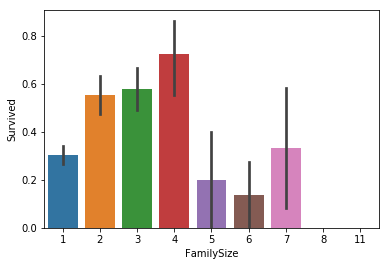

In [85]:
sns.barplot(data=train_df, x="FamilySize", y="Survived")

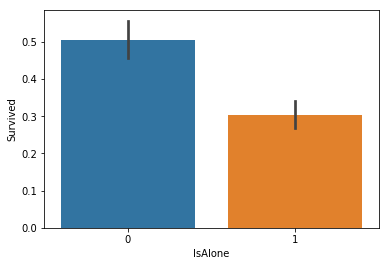

In [86]:
sns.barplot(data=train_df, x="IsAlone", y="Survived")

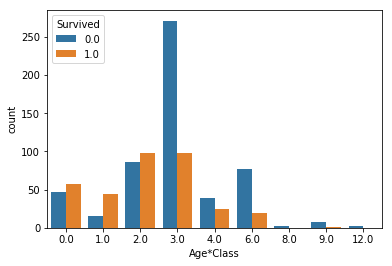

In [87]:
sns.countplot(data=train_df, x="Age*Class", hue="Survived")

In [88]:
train_df.head()

,Age,Age_Null_Flag,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,...,Ticket_Len,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev,FamilySize,IsAlone,Age*Class
0,1.0,0,1,0,0,0,0,0,0,0,...,9,0,0,0,1,0,0,2,0,3.0
1,2.0,0,0,0,0,1,0,0,0,0,...,8,0,0,0,0,1,0,2,0,2.0
2,1.0,0,1,0,0,0,0,0,0,0,...,16,0,0,1,0,0,0,1,1,3.0
3,2.0,0,0,0,0,1,0,0,0,0,...,6,0,0,0,0,1,0,2,0,2.0
4,2.0,0,1,0,0,0,0,0,0,0,...,6,0,0,0,1,0,0,1,1,6.0


In [89]:
test_df.head()

,Age,Age_Null_Flag,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,Cabin_Letter_G,...,Ticket_Len,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev,FamilySize,IsAlone,Age*Class
0,2.0,0,1,0,0,0,0,0,0,0,...,6,0,0,0,1,0,0,1,1,6.0
1,2.0,0,1,0,0,0,0,0,0,0,...,6,0,0,0,0,1,0,2,0,6.0
2,3.0,0,1,0,0,0,0,0,0,0,...,6,0,0,0,1,0,0,1,1,6.0
3,1.0,0,1,0,0,0,0,0,0,0,...,6,0,0,0,1,0,0,1,1,3.0
4,1.0,0,1,0,0,0,0,0,0,0,...,7,0,0,0,0,1,0,3,0,3.0


----

## fill missing Embarked 

In [90]:
freq_port = train_df.Embarked.dropna().mode()[0]
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)

/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


----

## Embarked categorical feature

### 1. Converting Embarked categorical feature to numeric

### 2. one hot encoding for Embarked categorical feature
2018/03/18 this is better than using converting categorical to numeric

In [91]:
train_test_df = pd.concat((train_df, test_df))
train_test_df = pd.get_dummies(train_test_df, columns=["Embarked"])

combine = [train_df, test_df]

train_df = train_test_df.iloc[:train_df.shape[0]]
test_df = train_test_df.iloc[train_df.shape[0]:]

test_df = test_df.drop("Survived", axis=1)

combine = [train_df, test_df]

In [92]:
train_df.head()

,Age,Age*Class,Age_Null_Flag,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,...,Ticket_Len,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev,Embarked_C,Embarked_Q,Embarked_S
0,1.0,3.0,0,1,0,0,0,0,0,0,...,9,0,0,0,1,0,0,0,0,1
1,2.0,2.0,0,0,0,0,1,0,0,0,...,8,0,0,0,0,1,0,1,0,0
2,1.0,3.0,0,1,0,0,0,0,0,0,...,16,0,0,1,0,0,0,0,0,1
3,2.0,2.0,0,0,0,0,1,0,0,0,...,6,0,0,0,0,1,0,0,0,1
4,2.0,6.0,0,1,0,0,0,0,0,0,...,6,0,0,0,1,0,0,0,0,1


In [93]:
test_df.head()

,Age,Age*Class,Age_Null_Flag,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,...,Ticket_Len,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev,Embarked_C,Embarked_Q,Embarked_S
0,2.0,6.0,0,1,0,0,0,0,0,0,...,6,0,0,0,1,0,0,0,1,0
1,2.0,6.0,0,1,0,0,0,0,0,0,...,6,0,0,0,0,1,0,0,0,1
2,3.0,6.0,0,1,0,0,0,0,0,0,...,6,0,0,0,1,0,0,0,1,0
3,1.0,3.0,0,1,0,0,0,0,0,0,...,6,0,0,0,1,0,0,0,0,1
4,1.0,3.0,0,1,0,0,0,0,0,0,...,7,0,0,0,0,1,0,0,0,1


----

## fill na of Fare in test data 

In [94]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
combine = [train_df, test_df]

In [95]:
test_df["Fare"].head()

0     7.8292
1     7.0000
2     9.6875
3     8.6625
4    12.2875
Name: Fare, dtype: float64

In [96]:
test_df.Fare.isna().any()

False

----

## make Fareband feature

In [97]:
pd.qcut(train_df['Fare'], 4).value_counts(dropna=False)

(7.91, 14.454]     224
(-0.001, 7.91]     223
(31.0, 512.329]    222
(14.454, 31.0]     222
Name: Fare, dtype: int64

In [98]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)

for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    #print(dataset['Fare'].value_counts(dropna=False))
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)

combine = [train_df, test_df]

/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/yuki/.local/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

In [99]:
train_df.Fare.head(10)

0    0
1    3
2    1
3    3
4    1
5    1
6    3
7    2
8    1
9    2
Name: Fare, dtype: int64

In [100]:
test_df.Fare.head(10)

0    0
1    0
2    1
3    1
4    1
5    1
6    0
7    2
8    0
9    2
Name: Fare, dtype: int64

### try more fare band number

- no difference

### keep Fare feature and add FareBand numerical feature¶

- not good result

----

## drop Name, PassengerId

In [101]:
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]

----

## final check data

In [102]:
train_df.head()

,Age,Age*Class,Age_Null_Flag,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,...,Ticket_Len,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev,Embarked_C,Embarked_Q,Embarked_S
0,1.0,3.0,0,1,0,0,0,0,0,0,...,9,0,0,0,1,0,0,0,0,1
1,2.0,2.0,0,0,0,0,1,0,0,0,...,8,0,0,0,0,1,0,1,0,0
2,1.0,3.0,0,1,0,0,0,0,0,0,...,16,0,0,1,0,0,0,0,0,1
3,2.0,2.0,0,0,0,0,1,0,0,0,...,6,0,0,0,0,1,0,0,0,1
4,2.0,6.0,0,1,0,0,0,0,0,0,...,6,0,0,0,1,0,0,0,0,1


In [103]:
train_df.columns

Index(['Age', 'Age*Class', 'Age_Null_Flag', 'Cabin_Letter_0', 'Cabin_Letter_A',
       'Cabin_Letter_B', 'Cabin_Letter_C', 'Cabin_Letter_D', 'Cabin_Letter_E',
       'Cabin_Letter_F', 'Cabin_Letter_G', 'Cabin_Letter_T', 'Cabin_num_0.0',
       'Cabin_num_1.0', 'Cabin_num_2.0', 'Cabin_num_nan', 'FamilySize', 'Fare',
       'IsAlone', 'Name_Len', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Survived',
       'Ticket_Len', 'Title_Dr', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Rev', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [104]:
test_df.head()

,Age,Age*Class,Age_Null_Flag,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,...,Ticket_Len,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev,Embarked_C,Embarked_Q,Embarked_S
0,2.0,6.0,0,1,0,0,0,0,0,0,...,6,0,0,0,1,0,0,0,1,0
1,2.0,6.0,0,1,0,0,0,0,0,0,...,6,0,0,0,0,1,0,0,0,1
2,3.0,6.0,0,1,0,0,0,0,0,0,...,6,0,0,0,1,0,0,0,1,0
3,1.0,3.0,0,1,0,0,0,0,0,0,...,6,0,0,0,1,0,0,0,0,1
4,1.0,3.0,0,1,0,0,0,0,0,0,...,7,0,0,0,0,1,0,0,0,1


In [105]:
test_df.columns

Index(['Age', 'Age*Class', 'Age_Null_Flag', 'Cabin_Letter_0', 'Cabin_Letter_A',
       'Cabin_Letter_B', 'Cabin_Letter_C', 'Cabin_Letter_D', 'Cabin_Letter_E',
       'Cabin_Letter_F', 'Cabin_Letter_G', 'Cabin_Letter_T', 'Cabin_num_0.0',
       'Cabin_num_1.0', 'Cabin_num_2.0', 'Cabin_num_nan', 'FamilySize', 'Fare',
       'IsAlone', 'Name_Len', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp',
       'Ticket_Len', 'Title_Dr', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Rev', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

----
# try to delete some features

### select family related feature
Parch, SibSp, FaimilySize, IsAlone

2018/03/18 Parch and SibSp only was best for almost all models

In [106]:
# keep FamilySize only

train_df = train_df.drop(['Parch', 'SibSp', 'IsAlone'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'IsAlone'], axis=1)
combine = [train_df, test_df]

- Age*Class is duplicated. Age and Pclass is enough, i think

- Name_Len looks no meaning

In [107]:
train_df = train_df.drop(['Name_Len'], axis=1)
test_df = test_df.drop(['Name_Len'], axis=1)
combine = [train_df, test_df]

- Ticket_Len looks no meaning

In [108]:
train_df = train_df.drop(['Ticket_Len'], axis=1)
test_df = test_df.drop(['Ticket_Len'], axis=1)
combine = [train_df, test_df]

- Cabin_Num looks no meaning. Cabin null feature is included in Cabinb_Letter value.

In [109]:
train_df = train_df.drop(['Cabin_num_0.0', 'Cabin_num_1.0',
                          'Cabin_num_2.0', 'Cabin_num_nan'], axis=1)
test_df = test_df.drop(['Cabin_num_0.0', 'Cabin_num_1.0',
                        'Cabin_num_2.0', 'Cabin_num_nan'], axis=1)

combine = [train_df, test_df]

In [110]:
print(train_df.shape, test_df.shape)
print(train_df.columns, test_df.columns)

(891, 26) (418, 26)
Index(['Age', 'Age*Class', 'Age_Null_Flag', 'Cabin_Letter_0', 'Cabin_Letter_A',
       'Cabin_Letter_B', 'Cabin_Letter_C', 'Cabin_Letter_D', 'Cabin_Letter_E',
       'Cabin_Letter_F', 'Cabin_Letter_G', 'Cabin_Letter_T', 'FamilySize',
       'Fare', 'Pclass', 'Sex', 'Survived', 'Title_Dr', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rev', 'Embarked_C',
       'Embarked_Q', 'Embarked_S'],
      dtype='object') Index(['Age', 'Age*Class', 'Age_Null_Flag', 'Cabin_Letter_0', 'Cabin_Letter_A',
       'Cabin_Letter_B', 'Cabin_Letter_C', 'Cabin_Letter_D', 'Cabin_Letter_E',
       'Cabin_Letter_F', 'Cabin_Letter_G', 'Cabin_Letter_T', 'FamilySize',
       'Fare', 'PassengerId', 'Pclass', 'Sex', 'Title_Dr', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rev', 'Embarked_C',
       'Embarked_Q', 'Embarked_S'],
      dtype='object')


In [111]:
train_df.head()

,Age,Age*Class,Age_Null_Flag,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,...,Survived,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev,Embarked_C,Embarked_Q,Embarked_S
0,1.0,3.0,0,1,0,0,0,0,0,0,...,0.0,0,0,0,1,0,0,0,0,1
1,2.0,2.0,0,0,0,0,1,0,0,0,...,1.0,0,0,0,0,1,0,1,0,0
2,1.0,3.0,0,1,0,0,0,0,0,0,...,1.0,0,0,1,0,0,0,0,0,1
3,2.0,2.0,0,0,0,0,1,0,0,0,...,1.0,0,0,0,0,1,0,0,0,1
4,2.0,6.0,0,1,0,0,0,0,0,0,...,0.0,0,0,0,1,0,0,0,0,1


In [112]:
test_df.head()

,Age,Age*Class,Age_Null_Flag,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,...,Sex,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev,Embarked_C,Embarked_Q,Embarked_S
0,2.0,6.0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,2.0,6.0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
2,3.0,6.0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,1.0,3.0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,1.0,3.0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1


----

# model and estimate

In [113]:
X_train_df = train_df.drop("Survived", axis=1)
y_train_df = train_df["Survived"]

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X_train_df, y_train_df, test_size=0.33, random_state=42)
print("train/test data shape", X_train.shape, X_test.shape)
# 33, 

train/test data shape (596, 25) (295, 25)


----

## SVC

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=3)]: Done 462 tasks      | elapsed:    3.0s
[Parallel(n_jobs=3)]: Done 1200 out of 1200 | elapsed:    7.7s finished


best parameters: {'svc__C': 500, 'svc__gamma': 0.01}
Mean cross-validated score of the best_estimator:  0.8338926174496645
test:  0.8169491525423729
confusion matrix:  [[154  21]
 [ 33  87]]

Rank|Score(std)|Params ['svc__C', 'svc__gamma']
1|0.833893(std:0.031230)|[500, 0.01]
2|0.832215(std:0.029095)|[70, 0.03]
2|0.832215(std:0.029095)|[80, 0.03]
2|0.832215(std:0.029130)|[1000, 0.005]
2|0.832215(std:0.031959)|[1000, 0.008]
6|0.830537(std:0.031556)|[30, 0.03]
6|0.830537(std:0.027422)|[30, 0.04]
6|0.830537(std:0.030285)|[50, 0.03]
6|0.830537(std:0.031556)|[500, 0.008]
10|0.827181(std:0.029504)|[90, 0.03]
10|0.827181(std:0.038072)|[500, 0.005]


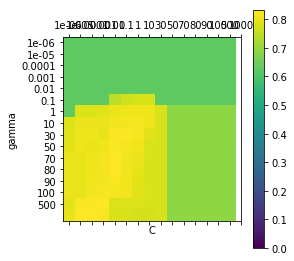

In [719]:
param_grid = {'svc__C': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 30, 50, 70, 80, 90, 100, 500, 1000],
              'svc__gamma': [0.001, 0.005, 0.008, 0.01, 0.03, 0.04, 0.05, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]}

pipe = make_pipeline(SVC())

grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=3, verbose=1)

# no meaning to use cross_val for grid_search model because it is incluced in grid search
#scores = cross_val_score(grid_search, X_train, y_train, cv=5, n_jobs=6)
#print("mean of train scores", scores.mean())

grid_search.fit(X_train, y_train)

plt.matshow(grid_search.cv_results_['mean_test_score'].reshape(16, -1),
            vmin=0, cmap="viridis")
plt.xlabel("C")
plt.ylabel("gamma")
plt.xticks(range(len(param_grid['svc__C'])), param_grid['svc__C'])
plt.yticks(range(len(param_grid['svc__gamma'])), param_grid['svc__C'])
plt.colorbar()

print("best parameters:", grid_search.best_params_)
print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
print("test: ", grid_search.score(X_test, y_test))
print("confusion matrix: ", confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test)))
print("")
report2(grid_search.cv_results_, n_top=10)

### svc, minmax scaler

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=3)]: Done 386 tasks      | elapsed:    2.6s
[Parallel(n_jobs=3)]: Done 1200 out of 1200 | elapsed:    8.0s finished


best parameters: {'svc__C': 100, 'svc__gamma': 0.1}
Mean cross-validated score of the best_estimator:  0.837248322147651
test:  0.8067796610169492
confusion matrix:  [[154  21]
 [ 36  84]]

Rank|Score(std)|Params ['svc__C', 'svc__gamma']
1|0.837248(std:0.036492)|[100, 0.1]
2|0.835570(std:0.043635)|[30, 0.1]
2|0.835570(std:0.044349)|[90, 0.05]
4|0.833893(std:0.039739)|[70, 0.04]
4|0.833893(std:0.039739)|[80, 0.04]
4|0.833893(std:0.039739)|[90, 0.03]
4|0.833893(std:0.039739)|[100, 0.03]
4|0.833893(std:0.046404)|[100, 0.05]
9|0.832215(std:0.039963)|[50, 0.04]
9|0.832215(std:0.041008)|[50, 0.05]
9|0.832215(std:0.042692)|[70, 0.05]
9|0.832215(std:0.042692)|[80, 0.05]
9|0.832215(std:0.035952)|[80, 0.1]
9|0.832215(std:0.033035)|[90, 0.1]
9|0.832215(std:0.035658)|[500, 0.04]
9|0.832215(std:0.037795)|[1000, 0.03]


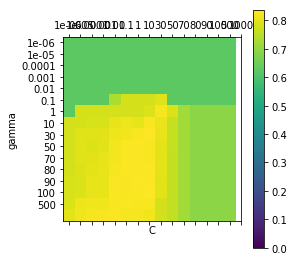

In [720]:
param_grid = {'svc__C': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 30, 50, 70, 80, 90, 100, 500, 1000],
              'svc__gamma': [0.001, 0.005, 0.008, 0.01, 0.03, 0.04, 0.05, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]}

pipe = make_pipeline(MinMaxScaler(), SVC())

grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=3, verbose=1)

# no meaning to use cross_val for grid_search model because it is incluced in grid search
#scores = cross_val_score(grid_search, X_train, y_train, cv=5, n_jobs=6)
#print("mean of train scores", scores.mean())

grid_search.fit(X_train, y_train)

plt.matshow(grid_search.cv_results_['mean_test_score'].reshape(16, -1),
            vmin=0, cmap="viridis")
plt.xlabel("C")
plt.ylabel("gamma")
plt.xticks(range(len(param_grid['svc__C'])), param_grid['svc__C'])
plt.yticks(range(len(param_grid['svc__gamma'])), param_grid['svc__C'])
plt.colorbar()

print("best parameters:", grid_search.best_params_)
print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
print("test: ", grid_search.score(X_test, y_test))
print("confusion matrix: ", confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test)))
print("")
report2(grid_search.cv_results_, n_top=10)

### svc, robust scaler

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=3)]: Done 462 tasks      | elapsed:    3.2s
[Parallel(n_jobs=3)]: Done 1200 out of 1200 | elapsed:    8.2s finished


best parameters: {'svc__C': 70, 'svc__gamma': 0.03}
Mean cross-validated score of the best_estimator:  0.8338926174496645
test:  0.8203389830508474
confusion matrix:  [[155  20]
 [ 33  87]]

Rank|Score(std)|Params ['svc__C', 'svc__gamma']
1|0.833893(std:0.026337)|[70, 0.03]
2|0.832215(std:0.032914)|[10, 0.05]
2|0.832215(std:0.028874)|[50, 0.03]
2|0.832215(std:0.026674)|[80, 0.03]
2|0.832215(std:0.028381)|[1000, 0.008]
6|0.830537(std:0.032118)|[30, 0.03]
6|0.830537(std:0.027422)|[30, 0.04]
6|0.830537(std:0.027422)|[500, 0.008]
6|0.830537(std:0.025944)|[500, 0.01]
10|0.828859(std:0.029892)|[1000, 0.005]
10|0.828859(std:0.024315)|[1000, 0.01]


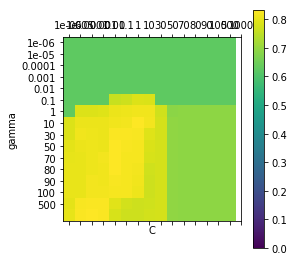

In [721]:
param_grid = {'svc__C': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 30, 50, 70, 80, 90, 100, 500, 1000],
              'svc__gamma': [0.001, 0.005, 0.008, 0.01, 0.03, 0.04, 0.05, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]}

pipe = make_pipeline(RobustScaler(), SVC())

grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=3, verbose=1)

# no meaning to use cross_val for grid_search model because it is incluced in grid search
#scores = cross_val_score(grid_search, X_train, y_train, cv=5, n_jobs=6)
#print("mean of train scores", scores.mean())

grid_search.fit(X_train, y_train)

plt.matshow(grid_search.cv_results_['mean_test_score'].reshape(16, -1),
            vmin=0, cmap="viridis")
plt.xlabel("C")
plt.ylabel("gamma")
plt.xticks(range(len(param_grid['svc__C'])), param_grid['svc__C'])
plt.yticks(range(len(param_grid['svc__gamma'])), param_grid['svc__C'])
plt.colorbar()

print("best parameters:", grid_search.best_params_)
print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
print("test: ", grid_search.score(X_test, y_test))
print("confusion matrix: ", confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test)))
print("")
report2(grid_search.cv_results_, n_top=10)

### svc, StandardScaler scaler

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=3)]: Done 462 tasks      | elapsed:    3.1s
[Parallel(n_jobs=3)]: Done 1200 out of 1200 | elapsed:    8.0s finished


best parameters: {'svc__C': 80, 'svc__gamma': 0.01}
Mean cross-validated score of the best_estimator:  0.8355704697986577
test:  0.8135593220338984
confusion matrix:  [[153  22]
 [ 33  87]]

Rank|Score(std)|Params ['svc__C', 'svc__gamma']
1|0.835570(std:0.024733)|[80, 0.01]
2|0.832215(std:0.025519)|[70, 0.01]
2|0.832215(std:0.026101)|[90, 0.01]
4|0.830537(std:0.033798)|[30, 0.01]
4|0.830537(std:0.028257)|[90, 0.008]
4|0.830537(std:0.028257)|[100, 0.008]
4|0.830537(std:0.026334)|[100, 0.01]
8|0.828859(std:0.031691)|[50, 0.008]
8|0.828859(std:0.029351)|[80, 0.008]
8|0.828859(std:0.024315)|[500, 0.008]


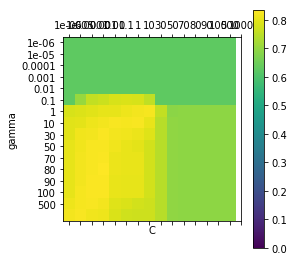

In [722]:
param_grid = {'svc__C': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 30, 50, 70, 80, 90, 100, 500, 1000],
              'svc__gamma': [0.001, 0.005, 0.008, 0.01, 0.03, 0.04, 0.05, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]}

pipe = make_pipeline(StandardScaler(), SVC())

grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=3, verbose=1)

# no meaning to use cross_val for grid_search model because it is incluced in grid search
#scores = cross_val_score(grid_search, X_train, y_train, cv=5, n_jobs=6)
#print("mean of train scores", scores.mean())

grid_search.fit(X_train, y_train)

plt.matshow(grid_search.cv_results_['mean_test_score'].reshape(16, -1),
            vmin=0, cmap="viridis")
plt.xlabel("C")
plt.ylabel("gamma")
plt.xticks(range(len(param_grid['svc__C'])), param_grid['svc__C'])
plt.yticks(range(len(param_grid['svc__gamma'])), param_grid['svc__C'])
plt.colorbar()

print("best parameters:", grid_search.best_params_)
print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
print("test: ", grid_search.score(X_test, y_test))
print("confusion matrix: ", confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test)))
print("")
report2(grid_search.cv_results_, n_top=10)

----

## KNeighborsClassifier

In [723]:
# no cale
param_grid = {'kneighborsclassifier__n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]}

pipe = make_pipeline(KNeighborsClassifier())

grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=3, verbose=1)
grid_search.fit(X_train, y_train)

print("best parameters:", grid_search.best_params_)
print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
print("test: ", grid_search.score(X_test, y_test))
print("confusion matrix: ", confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test)))
print("")
report2(grid_search.cv_results_, n_top=10)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
best parameters: {'kneighborsclassifier__n_neighbors': 3}
Mean cross-validated score of the best_estimator:  0.8070469798657718
test:  0.8101694915254237
confusion matrix:  [[149  26]
 [ 30  90]]

Rank|Score(std)|Params ['kneighborsclassifier__n_neighbors']
1|0.807047(std:0.050029)|[3]
2|0.788591(std:0.038696)|[5]
2|0.788591(std:0.041744)|[8]
2|0.788591(std:0.050709)|[15]
5|0.786913(std:0.032837)|[4]
5|0.786913(std:0.044489)|[7]
5|0.786913(std:0.047382)|[9]
8|0.785235(std:0.028473)|[10]
9|0.783557(std:0.029440)|[6]
10|0.781879(std:0.046434)|[20]


[Parallel(n_jobs=3)]: Done  55 out of  55 | elapsed:    0.3s finished


### minmax scaler

In [724]:
# minmax scaler
param_grid = {'kneighborsclassifier__n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]}

pipe = make_pipeline(MinMaxScaler(), KNeighborsClassifier())

grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=3, verbose=1)
grid_search.fit(X_train, y_train)

print("best parameters:", grid_search.best_params_)
print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
print("test: ", grid_search.score(X_test, y_test))
print("confusion matrix: ", confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test)))
print("")
report2(grid_search.cv_results_, n_top=10)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
best parameters: {'kneighborsclassifier__n_neighbors': 7}
Mean cross-validated score of the best_estimator:  0.8288590604026845
test:  0.8338983050847457
confusion matrix:  [[157  18]
 [ 31  89]]

Rank|Score(std)|Params ['kneighborsclassifier__n_neighbors']
1|0.828859(std:0.035462)|[7]
2|0.827181(std:0.031686)|[3]
3|0.825503(std:0.037070)|[5]
3|0.825503(std:0.035949)|[8]
5|0.820470(std:0.033602)|[4]
6|0.818792(std:0.033482)|[6]
6|0.818792(std:0.029764)|[15]
8|0.817114(std:0.041261)|[9]
8|0.817114(std:0.039644)|[10]
10|0.812081(std:0.023666)|[2]


[Parallel(n_jobs=3)]: Done  55 out of  55 | elapsed:    0.3s finished


### robust scaler

In [725]:
# robust scaler
param_grid = {'kneighborsclassifier__n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]}

pipe = make_pipeline(RobustScaler(), KNeighborsClassifier())

grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=3, verbose=1)
grid_search.fit(X_train, y_train)

print("best parameters:", grid_search.best_params_)
print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
print("test: ", grid_search.score(X_test, y_test))
print("confusion matrix: ", confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test)))
print("")
report2(grid_search.cv_results_, n_top=10)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
best parameters: {'kneighborsclassifier__n_neighbors': 3}
Mean cross-validated score of the best_estimator:  0.8003355704697986
test:  0.8101694915254237
confusion matrix:  [[151  24]
 [ 32  88]]

Rank|Score(std)|Params ['kneighborsclassifier__n_neighbors']
1|0.800336(std:0.050638)|[3]
2|0.795302(std:0.039001)|[10]
3|0.793624(std:0.043365)|[5]
3|0.793624(std:0.049273)|[15]
5|0.786913(std:0.035758)|[8]
6|0.785235(std:0.026634)|[6]
7|0.783557(std:0.036947)|[4]
7|0.783557(std:0.046288)|[7]
9|0.781879(std:0.022140)|[2]
9|0.781879(std:0.049654)|[9]


[Parallel(n_jobs=3)]: Done  55 out of  55 | elapsed:    0.2s finished


### StandardScaler

In [726]:
# StandardScaler
param_grid = {'kneighborsclassifier__n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]}

pipe = make_pipeline(StandardScaler(), KNeighborsClassifier())

grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=3, verbose=1)
grid_search.fit(X_train, y_train)

print("best parameters:", grid_search.best_params_)
print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
print("test: ", grid_search.score(X_test, y_test))
print("confusion matrix: ", confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test)))
print("")
report2(grid_search.cv_results_, n_top=10)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
best parameters: {'kneighborsclassifier__n_neighbors': 3}
Mean cross-validated score of the best_estimator:  0.8120805369127517
test:  0.8203389830508474
confusion matrix:  [[156  19]
 [ 34  86]]

Rank|Score(std)|Params ['kneighborsclassifier__n_neighbors']
1|0.812081(std:0.013748)|[3]
2|0.802013(std:0.017276)|[4]
3|0.796980(std:0.025427)|[7]
3|0.796980(std:0.033294)|[15]
5|0.795302(std:0.037622)|[8]
6|0.791946(std:0.026042)|[6]
7|0.790268(std:0.018070)|[5]
7|0.790268(std:0.041217)|[9]
9|0.785235(std:0.016588)|[2]
9|0.785235(std:0.042715)|[10]


[Parallel(n_jobs=3)]: Done  55 out of  55 | elapsed:    0.3s finished


----

# random forest result for compare

**normal**

In [727]:
"""
# too wide
param_grid = {'randomforestclassifier__max_depth':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 15, 20, 25 None],
             'randomforestclassifier__max_features': [1, 'sqrt', 'log2', None],
             'randomforestclassifier__min_samples_leaf': [1,2,3,4,5],
             "randomforestclassifier__min_samples_split" : [2,3,4,5,6,7],
             'randomforestclassifier__n_estimators': [10, 20, 30, 40, 50, 60, 70, 100],
              }
"""
# narrow down
param_grid = {'randomforestclassifier__max_depth':[5, 7, 8, 9,  13, 15, 20, 25, None],
             'randomforestclassifier__max_features': [1, 'sqrt', 'log2'],
#             'randomforestclassifier__min_samples_leaf': [1,2,3 ,5],
             "randomforestclassifier__min_samples_split" : [2,3, 5,6,7],
             'randomforestclassifier__n_estimators': [20, 30, 40,  60, 100],
              }
pipe = make_pipeline(RandomForestClassifier())

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=6, verbose=1)
grid_search.fit(X_train, y_train)

print("best parameters:", grid_search.best_params_)
print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
print("test: ", grid_search.score(X_test, y_test))
print("confusion matrix: ", confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test)))
print("")
report2(grid_search.cv_results_, n_top=10)

Fitting 5 folds for each of 675 candidates, totalling 3375 fits


[Parallel(n_jobs=6)]: Done 168 tasks      | elapsed:    2.6s
[Parallel(n_jobs=6)]: Done 1068 tasks      | elapsed:   14.6s
[Parallel(n_jobs=6)]: Done 2568 tasks      | elapsed:   35.3s


best parameters: {'randomforestclassifier__max_depth': 5, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 30}
Mean cross-validated score of the best_estimator:  0.8406040268456376
test:  0.8203389830508474
confusion matrix:  [[158  17]
 [ 36  84]]

Rank|Score(std)|Params ['randomforestclassifier__max_depth', 'randomforestclassifier__max_features', 'randomforestclassifier__min_samples_split', 'randomforestclassifier__n_estimators']
1|0.840604(std:0.039782)|[5, 'sqrt', 2, 30]
2|0.837248(std:0.035074)|[15, 'sqrt', 7, 20]
3|0.835570(std:0.041721)|[5, 'sqrt', 2, 40]
3|0.835570(std:0.040678)|[5, 'sqrt', 3, 20]
3|0.835570(std:0.028742)|[7, 'log2', 3, 40]
3|0.835570(std:0.037411)|[7, 'log2', 7, 30]
3|0.835570(std:0.024890)|[8, 'log2', 5, 20]
8|0.833893(std:0.039120)|[5, 'log2', 3, 100]
8|0.833893(std:0.032020)|[7, 'sqrt', 6, 30]
8|0.833893(std:0.033560)|[8, 'log2', 3, 40]
8|0.833893(std:0.025619)|[9, 1, 3, 

[Parallel(n_jobs=6)]: Done 3375 out of 3375 | elapsed:   46.4s finished


In [728]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(grid_search.best_estimator_.named_steps["randomforestclassifier"].feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

,variable,importance
19,Title_Mr,0.228370
15,Sex,0.187503
14,Pclass,0.111568
12,FamilySize,0.066135
20,Title_Mrs,0.063738
1,Age*Class,0.063187
18,Title_Miss,0.053744
3,Cabin_Letter_0,0.053744
24,Embarked_S,0.031050
13,Fare,0.029025


In [729]:
test_df.isnull().any()

Age               False
Age*Class         False
Age_Null_Flag     False
Cabin_Letter_0    False
Cabin_Letter_A    False
Cabin_Letter_B    False
Cabin_Letter_C    False
Cabin_Letter_D    False
Cabin_Letter_E    False
Cabin_Letter_F    False
Cabin_Letter_G    False
Cabin_Letter_T    False
FamilySize        False
Fare              False
PassengerId       False
Pclass            False
Sex               False
Title_Dr          False
Title_Master      False
Title_Miss        False
Title_Mr          False
Title_Mrs         False
Title_Rev         False
Embarked_C        False
Embarked_Q        False
Embarked_S        False
dtype: bool

In [730]:
test_df

,Age,Age*Class,Age_Null_Flag,Cabin_Letter_0,Cabin_Letter_A,Cabin_Letter_B,Cabin_Letter_C,Cabin_Letter_D,Cabin_Letter_E,Cabin_Letter_F,...,Sex,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev,Embarked_C,Embarked_Q,Embarked_S
0,2.0,6.0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,2.0,6.0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
2,3.0,6.0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,1.0,3.0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,1.0,3.0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
5,0.0,0.0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
6,1.0,3.0,0,1,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
7,1.0,2.0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
8,1.0,3.0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,1,0,1,0,0
9,1.0,3.0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [731]:
pipe.fit(X_train_df, y_train_df)

test_df_noid = test_df.drop("PassengerId", axis=1).copy()
y_pred = pipe.predict(test_df_noid).astype(int)

submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"].astype(int),
        "Survived": y_pred
    })
submission.to_csv('../output/submission_randomforest.csv', index=False)

**just trial of PolynomialFeatures(degree=2)**

In [732]:
"""
# too wide
param_grid = {'randomforestclassifier__max_depth':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 15, 20, 25 None],
             'randomforestclassifier__max_features': [1, 'sqrt', 'log2', None],
             'randomforestclassifier__min_samples_leaf': [1,2,3,4,5],
             "randomforestclassifier__min_samples_split" : [2,3,4,5,6,7],
             'randomforestclassifier__n_estimators': [10, 20, 30, 40, 50, 60, 70, 100],
              }
"""
# narrow down
param_grid = {'randomforestclassifier__max_depth':[5, 7, 8, 9,  13, 15, 20, 25, None],
             'randomforestclassifier__max_features': [1, 'sqrt', 'log2'],
#             'randomforestclassifier__min_samples_leaf': [1,2,3 ,5],
             "randomforestclassifier__min_samples_split" : [2,3, 5,6,7],
             'randomforestclassifier__n_estimators': [20, 30, 40,  60, 100],
              }
pipe = make_pipeline(PolynomialFeatures(degree=2), RandomForestClassifier())

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=6, verbose=1)
grid_search.fit(X_train, y_train)

print("best parameters:", grid_search.best_params_)
print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
print("test: ", grid_search.score(X_test, y_test))
print("confusion matrix: ", confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test)))
print("")
report2(grid_search.cv_results_, n_top=10)

Fitting 5 folds for each of 675 candidates, totalling 3375 fits


[Parallel(n_jobs=6)]: Done 220 tasks      | elapsed:    3.7s
[Parallel(n_jobs=6)]: Done 1420 tasks      | elapsed:   23.4s
[Parallel(n_jobs=6)]: Done 3080 tasks      | elapsed:   54.9s
[Parallel(n_jobs=6)]: Done 3364 out of 3375 | elapsed:  1.0min remaining:    0.2s


best parameters: {'randomforestclassifier__max_depth': 5, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_split': 3, 'randomforestclassifier__n_estimators': 30}
Mean cross-validated score of the best_estimator:  0.837248322147651
test:  0.8169491525423729
confusion matrix:  [[155  20]
 [ 34  86]]

Rank|Score(std)|Params ['randomforestclassifier__max_depth', 'randomforestclassifier__max_features', 'randomforestclassifier__min_samples_split', 'randomforestclassifier__n_estimators']
1|0.837248(std:0.044912)|[5, 'sqrt', 3, 30]
1|0.837248(std:0.029975)|[8, 'log2', 7, 100]
3|0.835570(std:0.032336)|[7, 'log2', 5, 60]
3|0.835570(std:0.033976)|[7, 'log2', 7, 40]
3|0.835570(std:0.027369)|[8, 1, 7, 20]
3|0.835570(std:0.041323)|[8, 'log2', 6, 20]
3|0.835570(std:0.030142)|[8, 'log2', 6, 100]
3|0.835570(std:0.026707)|[9, 'log2', 3, 30]
9|0.833893(std:0.032523)|[5, 'sqrt', 2, 30]
9|0.833893(std:0.033296)|[5, 'sqrt', 6, 100]
9|0.833893(std:0.037076)|[7, 1, 3, 40]
9

[Parallel(n_jobs=6)]: Done 3375 out of 3375 | elapsed:  1.0min finished


In [733]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(grid_search.best_estimator_.named_steps["randomforestclassifier"].feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

,variable,importance
286,NaN,0.080575
45,NaN,0.049780
114,NaN,0.038832
263,NaN,0.037371
41,NaN,0.034296
330,NaN,0.031790
20,Title_Mrs,0.031536
46,NaN,0.030612
295,NaN,0.030241
16,Title_Dr,0.025806


----

## XGBoost

----

## AdaBoostClassifier

----

## GradientBoostingClassifier

In [734]:
"""
# too wide
param_grid = {'learning_rate': [0.001, 0.005, 0.007, 0.01, 0.02, 0.05, 0.1, 0.2],
              'max_depth':[1,2,3,4,5,6,7,8],
              'max_features': [None, 'sqrt', 'log2'],
              'min_samples_leaf': [1, 2, 3, 4, 5, 6],
              'min_samples_split':[2, 3, 4, 5, 6],
              'n_estimators': [3, 5, 7, 10, 50, 100, 200, 300, 400, 500],
              }
"""

# narrow in specific region
param_grid = {'learning_rate': [0.005, 0.007, 0.01, 0.02, 0.05, 0.1, 0.2],
              'max_depth':[3,4,5,6,7],
              'max_features': [None, 'sqrt', 'log2'],
#              'min_samples_leaf': [1, 2, 3, 4, 5],
              'min_samples_split':[2, 3, 4, 5, 6],
              'n_estimators': [7, 10, 50, 100, 200, 300, 400, 500],
              }

grid_search = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=5, n_jobs=6, verbose=1)
grid_search.fit(X_train, y_train)

print("best parameters:", grid_search.best_params_)
print("Mean cross-validated score of the best_estimator: ", grid_search.best_score_)
print("test: ", grid_search.score(X_test, y_test))
print("confusion matrix: ", confusion_matrix(y_test, grid_search.best_estimator_.predict(X_test)))
print("")
report2(grid_search.cv_results_, n_top=10)

Fitting 5 folds for each of 4200 candidates, totalling 21000 fits


[Parallel(n_jobs=6)]: Done 332 tasks      | elapsed:    8.4s
[Parallel(n_jobs=6)]: Done 844 tasks      | elapsed:   22.3s
[Parallel(n_jobs=6)]: Done 1333 tasks      | elapsed:   39.0s
[Parallel(n_jobs=6)]: Done 1896 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 2486 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done 3036 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 4314 tasks      | elapsed:  3.0min
[Parallel(n_jobs=6)]: Done 5351 tasks      | elapsed:  3.9min
[Parallel(n_jobs=6)]: Done 6344 tasks      | elapsed:  4.9min
[Parallel(n_jobs=6)]: Done 8068 tasks      | elapsed:  6.0min
[Parallel(n_jobs=6)]: Done 9215 tasks      | elapsed:  7.2min
[Parallel(n_jobs=6)]: Done 11219 tasks      | elapsed:  8.4min
[Parallel(n_jobs=6)]: Done 12915 tasks      | elapsed:  9.7min
[Parallel(n_jobs=6)]: Done 14773 tasks      | elapsed: 11.2min
[Parallel(n_jobs=6)]: Done 17137 tasks      | elapsed: 12.7min
[Parallel(n_jobs=6)]: Done 19353 tasks      | elapsed: 14.3min
[Para

best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'max_features': 'log2', 'min_samples_split': 3, 'n_estimators': 100}
Mean cross-validated score of the best_estimator:  0.8389261744966443
test:  0.823728813559322
confusion matrix:  [[155  20]
 [ 32  88]]

Rank|Score(std)|Params ['learning_rate', 'max_depth', 'max_features', 'min_samples_split', 'n_estimators']
1|0.838926(std:0.034610)|[0.1, 3, 'log2', 3, 100]
2|0.837248(std:0.032162)|[0.1, 6, 'log2', 6, 10]
3|0.835570(std:0.033386)|[0.005, 4, 'log2', 4, 500]
3|0.835570(std:0.045235)|[0.007, 3, 'log2', 6, 500]
3|0.835570(std:0.031270)|[0.007, 4, 'sqrt', 3, 300]
3|0.835570(std:0.043504)|[0.01, 3, 'log2', 2, 400]
3|0.835570(std:0.042988)|[0.01, 3, 'log2', 3, 400]
3|0.835570(std:0.039821)|[0.01, 3, 'log2', 5, 400]
3|0.835570(std:0.037713)|[0.01, 4, 'sqrt', 5, 200]
3|0.835570(std:0.035776)|[0.05, 4, 'log2', 6, 50]
3|0.835570(std:0.039695)|[0.2, 4, 'sqrt', 6, 7]
3|0.835570(std:0.027061)|[0.2, 6, 'sqrt', 3, 10]


In [735]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(grid_search.best_estimator_.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

,variable,importance
12,FamilySize,0.131525
19,Title_Mr,0.108856
1,Age*Class,0.090218
14,Pclass,0.086685
13,Fare,0.074386
0,Age,0.053754
15,Sex,0.049200
20,Title_Mrs,0.044714
8,Cabin_Letter_E,0.036897
16,Title_Dr,0.033470


**for submit, make model by best par and fit to all train data**

In [736]:
pipe = make_pipeline(GradientBoostingClassifier(learning_rate=0.2,
                                                max_depth=5,
                                                max_features="sqrt",
#                                                min_samples_leaf=2,
                                                min_samples_split=6,
                                                n_estimators=10))
pipe.fit(X_train, y_train)
print("test: ", pipe.score(X_test, y_test))
print("confusion matrix: ", confusion_matrix(y_test, pipe.predict(X_test)))

scores = cross_val_score(pipe, X_train_df, y_train_df, n_jobs=3)
print("mean of cross val score for X_train_df: ", scores.mean())

test:  0.823728813559322
confusion matrix:  [[157  18]
 [ 34  86]]
mean of cross val score for X_train_df:  0.8260381593714926


In [737]:
pipe.fit(X_train_df, y_train_df)

test_df_noid = test_df.drop("PassengerId", axis=1).copy()
y_pred = pipe.predict(test_df_noid).astype(int)

submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"].astype(int),
        "Survived": y_pred
    })
submission.to_csv('../output/submission_gradientboosting.csv', index=False)

In [738]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(pipe.named_steps["gradientboostingclassifier"].feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

,variable,importance
19,Title_Mr,2.405385e-01
15,Sex,1.474709e-01
14,Pclass,1.245968e-01
12,FamilySize,7.944875e-02
13,Fare,6.912715e-02
1,Age*Class,5.085074e-02
17,Title_Master,4.235949e-02
20,Title_Mrs,4.134922e-02
3,Cabin_Letter_0,3.507841e-02
18,Title_Miss,2.959389e-02


**just trial of PolynomialFeatures(degree=2)**

In [739]:
pipe = make_pipeline(PolynomialFeatures(degree=2), 
                     GradientBoostingClassifier(learning_rate=0.05,
                                                max_depth=4,
                                                max_features="sqrt",
#                                                min_samples_leaf=2,
                                                min_samples_split=5,
                                                n_estimators=50))
pipe.fit(X_train, y_train)
print("test: ", pipe.score(X_test, y_test))
print("confusion matrix: ", confusion_matrix(y_test, pipe.predict(X_test)))

scores = cross_val_score(pipe, X_train_df, y_train_df, n_jobs=3)
print("mean of cross val score for X_train_df: ", scores.mean())


test:  0.823728813559322
confusion matrix:  [[154  21]
 [ 31  89]]
mean of cross val score for X_train_df:  0.8204264870931538


In [740]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(pipe.named_steps["gradientboostingclassifier"].feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

,variable,importance
267,NaN,0.040035
41,NaN,0.039057
114,NaN,0.036736
263,NaN,0.030289
286,NaN,0.028153
64,NaN,0.026609
291,NaN,0.024532
295,NaN,0.023226
45,NaN,0.023052
20,Title_Mrs,0.022954


** polynominal and pca**

In [741]:
pipe = make_pipeline(PolynomialFeatures(degree=2, interaction_only=False),
                     GradientBoostingClassifier(learning_rate=0.05,
                                                max_depth=4,
                                                max_features="sqrt",
#                                                min_samples_leaf=2,
                                                min_samples_split=5,
                                                n_estimators=50))
pipe.fit(X_train, y_train)
print("test: ", pipe.score(X_test, y_test))
print("confusion matrix: ", confusion_matrix(y_test, pipe.predict(X_test)))

scores = cross_val_score(pipe, X_train_df, y_train_df, n_jobs=3)
print("mean of cross val score for X_train_df: ", scores.mean())


test:  0.8169491525423729
confusion matrix:  [[154  21]
 [ 33  87]]
mean of cross val score for X_train_df:  0.8215488215488215


In [742]:
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(pipe.named_steps["gradientboostingclassifier"].feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

,variable,importance
16,Title_Dr,0.052225
286,NaN,0.047717
15,Sex,0.030542
267,NaN,0.027259
296,NaN,0.027234
65,NaN,0.025231
330,NaN,0.024979
289,NaN,0.024446
109,NaN,0.023115
41,NaN,0.020995
